In [1]:
# use the langchain pre-release for latest features
# pip install --pre -U langchain langchain-ollama, langchain-chroma, langchain-core langchain-community

# for stable version once v1 is released
# pip install langchain langchain-ollama, langchain-chroma, langchain-core langchain-community

In [2]:
"""
SQL Agent with Dedicated Tools using create_agent
Using employees.db database with create_agent approach
"""

import re

# Core imports
from langchain_ollama import ChatOllama
from langchain_community.utilities import SQLDatabase
from langchain_core.tools import tool
from langchain_core.messages import SystemMessage
from langchain.agents import create_agent

from dotenv import load_dotenv
load_dotenv()


True

In [3]:

# ============================================================================
# STEP 1: DATABASE SETUP
# ============================================================================
print("Setting up employees database...")


# Connect to employees database
db = SQLDatabase.from_uri("sqlite:///db/employees.db")

# Check connection and get basic info
try:
    # Test connection by getting table names
    tables = db.get_usable_table_names()
    print(f"✓ Database connected successfully")
    print(f"✓ Found {len(tables)} tables: {', '.join(tables)}")
    
except Exception as e:
    print(f"✗ Database connection failed: {e}")

# Get schema information
SCHEMA = db.get_table_info()
# print("\nDatabase Schema:", SCHEMA)
print("✓ Connected to employees database")


Setting up employees database...
✓ Database connected successfully
✓ Found 6 tables: departments, dept_emp, dept_manager, employees, salaries, titles
✓ Connected to employees database


In [4]:

# ============================================================================
# STEP 2: MODELS SETUP
# ============================================================================
# Using ChatOllama
llm = ChatOllama(
    model="qwen3:30b", 
    base_url="http://localhost:11434",
    temperature=0
)

response = llm.invoke("Hello, how are you?")
response.pretty_print()
print("✓ Initialized Ollama chat model")


================================== Ai Message ==================================

<think>
Okay, the user greeted me with 'Hello, how are you?'. First, I need to respond politely. Since I'm an AI, I should clarify that I don't have feelings but am here to help. Keep it friendly and open-ended to encourage them to ask for help.

Next, check if there's any hidden need. Maybe they're testing if I'm a real person or just making conversation. I should keep it simple and not overcomplicate.

Also, make sure the response is in the same language as the query, which is English. Avoid any markdown formatting. Keep it natural and conversational.

Wait, the user might be looking for a quick chat, but as an AI, my main role is to assist. So after greeting, offer help. Maybe they have a specific question or need assistance with something. So the response should be welcoming and prompt them to state their request.

Check for any cultural nuances. 'How are you?' is a common greeting, so a standard resp

In [5]:

# ============================================================================
# STEP 3: SQL TOOLS - One for each step
# ============================================================================

@tool
def get_database_schema(table_name: str = None) -> str:
    """Get database schema information for SQL query generation.
    Use this first to understand table structure before creating queries."""
    print(f"🔍 Getting schema for: {table_name if table_name else 'all tables'}")
    
    if table_name:
        try:
            # Get specific table info
            tables = db.get_usable_table_names()
            if table_name.lower() in [t.lower() for t in tables]:
                result = db.get_table_info([table_name])
                print(f"✓ Retrieved schema for table: {table_name}")
                return result
            else:
                return f"Error: Table '{table_name}' not found. Available tables: {', '.join(tables)}"
        except Exception as e:
            return f"Error getting table info: {e}"
    else:
        # Get all schema info
        print("✓ Retrieved full database schema")
        return SCHEMA


In [6]:

@tool
def generate_sql_query(question: str, schema_info: str = None) -> str:
    """Generate a SQL SELECT query from a natural language question using database schema.
    Always use this after getting schema information."""
    print(f"🔧 Generating SQL for: {question[:100]}...")
    
    # Use provided schema or get full schema
    schema_to_use = schema_info if schema_info else SCHEMA
    
    prompt = f"""
                Based on this database schema:
                {schema_to_use}

                Generate a SQL query to answer this question: {question}

                Rules:
                - Use only SELECT statements
                - Include only existing columns and tables
                - Add appropriate WHERE, GROUP BY, ORDER BY clauses as needed
                - Limit results to 10 rows unless specified otherwise
                - Use proper SQL syntax for SQLite

                Return only the SQL query, nothing else.
                """
    
    try:
        response = llm.invoke(prompt)
        query = response.content.strip()
        print(f"✓ Generated SQL query")
        return query
    except Exception as e:
        return f"Error generating query: {e}"


In [7]:
@tool
def validate_sql_query(query: str) -> str:
    """Validate SQL query for safety and syntax before execution.
    Returns 'Valid: <query>' if safe or 'Error: <message>' if unsafe."""
    print(f"🔍 Validating SQL: {query[:100]}...")
    
    # Safety checks
    query = query.strip()
    
    # Remove common SQL formatting
    clean_query = re.sub(r'```sql\s*', '', query, flags=re.IGNORECASE)
    clean_query = re.sub(r'```\s*', '', clean_query)
    clean_query = clean_query.strip()
    
    # Block multiple statements
    if clean_query.count(";") > 1 or (clean_query.endswith(";") and ";" in clean_query[:-1]):
        return "Error: Multiple statements not allowed"
    
    clean_query = clean_query.rstrip(";").strip()
    
    # Must be SELECT only
    if not clean_query.lower().startswith("select"):
        return "Error: Only SELECT statements allowed"
    
    # Block dangerous operations
    dangerous_patterns = [
        r'\b(INSERT|UPDATE|DELETE|ALTER|DROP|CREATE|REPLACE|TRUNCATE)\b',
        r'\b(EXEC|EXECUTE)\b',
        r'--',  # SQL comments
        r'/\*',  # Block comments
    ]
    
    for pattern in dangerous_patterns:
        if re.search(pattern, clean_query, re.IGNORECASE):
            return f"Error: Unsafe SQL pattern detected"
    
    # Basic syntax validation
    try:
        # Simple parsing check
        if clean_query.lower().count('select') != 1:
            return "Error: Multiple SELECT statements not allowed"
        
        # Check for balanced parentheses
        if clean_query.count('(') != clean_query.count(')'):
            return "Error: Unbalanced parentheses"
        
        print("✓ Query validation passed")
        return f"Valid: {clean_query}"
        
    except Exception as e:
        return f"Error: Syntax validation failed: {e}"


In [8]:

@tool
def execute_sql_query(query: str) -> str:
    """Execute a validated SQL query and return results.
    Only use this after validating the query for safety."""
    print(f"🚀 Executing SQL: {query[:100]}...")
    
    try:
        # Clean the query
        clean_query = query.strip()
        if clean_query.startswith("Valid: "):
            clean_query = clean_query[7:]  # Remove "Valid: " prefix
        
        clean_query = re.sub(r'```sql\s*', '', clean_query, flags=re.IGNORECASE)
        clean_query = re.sub(r'```\s*', '', clean_query)
        clean_query = clean_query.strip().rstrip(";")
        
        # Execute query
        result = db.run(clean_query)
        print("✓ Query executed successfully")
        
        if result:
            return f"Query Results:\n{result}"
        else:
            return "Query executed successfully but returned no results."
            
    except Exception as e:
        error_msg = f"Execution Error: {str(e)}"
        print(f"✗ {error_msg}")
        return error_msg


In [9]:
@tool
def fix_sql_error(original_query: str, error_message: str, question: str) -> str:
    """Fix a failed SQL query by analyzing the error and generating a corrected version.
    Use this when validation or execution fails."""
    print(f"🔧 Fixing SQL error: {error_message[:100]}...")
    
    fix_prompt = f"""
                    The following SQL query failed:
                    Query: {original_query}
                    Error: {error_message}
                    Original Question: {question}

                    Database Schema:
                    {SCHEMA}

                    Analyze the error and provide a corrected SQL query that:
                    1. Fixes the specific error mentioned
                    2. Still answers the original question
                    3. Uses only valid table and column names from the schema
                    4. Follows SQLite syntax rules

                    Return only the corrected SQL query, nothing else.
                    """
    
    try:
        response = llm.invoke(fix_prompt)
        fixed_query = response.content.strip()
        print("✓ Generated fixed SQL query")
        return fixed_query
    except Exception as e:
        return f"Error generating fix: {e}"


In [10]:

@tool
def analyze_query_results(question: str, query: str, results: str) -> str:
    """Convert SQL query results into a natural language answer.
    Use this as the final step to provide a user-friendly response."""
    print("📊 Analyzing results and generating answer...")
    
    analysis_prompt = f"""
Original Question: {question}
SQL Query Used: {query}
Query Results: {results}

Provide a clear, natural language answer to the original question based on the query results.
Be specific and include relevant numbers/data from the results.
If the results are empty or unclear, mention that as well.
"""
    
    try:
        response = llm.invoke(analysis_prompt)
        answer = response.content.strip()
        print("✓ Generated natural language answer")
        return answer
    except Exception as e:
        return f"Error analyzing results: {e}"

print("✓ Created all SQL workflow tools")


✓ Created all SQL workflow tools


In [11]:

# ============================================================================
# STEP 4: SYSTEM PROMPT
# ============================================================================

SQL_SYSTEM_PROMPT = f"""You are an expert SQL analyst working with an employees database.

Database Schema:
{SCHEMA}

Your workflow for answering questions:
1. Use `get_database_schema` first to understand available tables and columns (if needed)
2. Use `generate_sql_query` to create SQL based on the question
3. Use `validate_sql_query` to check the query for safety and syntax
4. Use `execute_sql_query` to run the validated query
5. If there's an error, use `fix_sql_error` to correct it and try again (up to 3 times)
6. Use `analyze_query_results` to provide a natural language answer

Rules:
- Always follow the workflow step by step
- If a query fails, use the fix tool and try again
- Provide clear, informative answers
- Be precise with table and column names
- Handle errors gracefully and try to fix them
- If you fail after 3 attempts, explain what went wrong

Available tools for each step:
- get_database_schema: Get table structure info
- generate_sql_query: Create SQL from question
- validate_sql_query: Check query safety/syntax  
- execute_sql_query: Run the query
- fix_sql_error: Fix failed queries
- analyze_query_results: Generate natural language answer

Remember: Always validate queries before executing them for safety.
"""

In [12]:
# ============================================================================
# STEP 5: CREATE AGENT
# ============================================================================

# All tools for the agent
tools = [
    get_database_schema,
    generate_sql_query,
    validate_sql_query, 
    execute_sql_query,
    fix_sql_error,
    # analyze_query_results
]

# Create the SQL agent using create_agent
sql_agent = create_agent(
    llm, 
    tools, 
    prompt=SystemMessage(content=SQL_SYSTEM_PROMPT)
)

print("✓ Created SQL agent with create_agent")


✓ Created SQL agent with create_agent


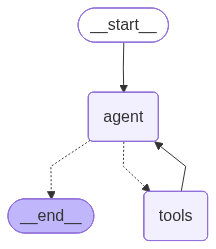

In [13]:
sql_agent

In [14]:

# ============================================================================
# STEP 6: QUERY FUNCTIONS 
# ============================================================================

def ask_sql(question: str):
    """Ask the SQL agent a question using the full workflow."""
    print(f"\n{'='*60}")
    print(f"SQL AGENT - Question: {question}")
    print('='*60)
    
    for event in sql_agent.stream(
        {"messages": [{"role": "user", "content": question}]},
        stream_mode="values"
    ):
        msg = event["messages"][-1]
        
        # Show tool usage
        if hasattr(msg, 'tool_calls') and msg.tool_calls:
            for tc in msg.tool_calls:
                print(f"\n🔧 Using: {tc['name']}")
                # Show args for key tools
                args_str = str(tc['args'])
                if len(args_str) > 200:
                    args_str = args_str[:200] + "..."
                print(f"Args: {args_str}")
        
        # Show final answer
        elif hasattr(msg, 'content') and msg.content:
            print(f"\n💬 Answer:\n{msg.content}")


In [15]:

# ============================================================================
# STEP 7: Chat SQL
# ============================================================================

def chat_sql():
    """Interactive SQL chat."""
    print("\n🤖 SQL Agent Chat - Type 'quit' to exit")
    print("Ask questions about the employees database")
    print("The agent will use dedicated tools for each step of the workflow")
    
    while True:
        question = input("\nYour question: ").strip()
        if question.lower() in ['quit', 'exit', 'q']:
            break
        if question:
            ask_sql(question)




In [16]:
chat_sql()


🤖 SQL Agent Chat - Type 'quit' to exit
Ask questions about the employees database
The agent will use dedicated tools for each step of the workflow

SQL AGENT - Question: how many employees are in each department

💬 Answer:
how many employees are in each department

🔧 Using: generate_sql_query
Args: {'question': 'how many employees are in each department', 'schema_info': 'CREATE TABLE departments (dept_no CHAR(4) NOT NULL, dept_name VARCHAR(40) NOT NULL, PRIMARY KEY (dept_no), UNIQUE (dept_name))...
🔧 Generating SQL for: how many employees are in each department...
✓ Generated SQL query

💬 Answer:
<think>
Okay, let's see. The user is asking for a SQL query to find how many employees are in each department. Hmm, I need to look at the database schema provided.

First, the departments table has dept_no and dept_name. The dept_emp table links employees to departments with emp_no and dept_no. So to count employees per department, I should join departments with dept_emp.

Wait, the dept_emp 